In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import scipy.io as scio
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

import time


# mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator

In [2]:
#导入基本参数
F=-20
rho= 1180
L= 1.5
# EI= 3e9*0.05*0.05**3/12
A=0.05*0.05
w0=5*2*np.pi
a=L/2

# domain = (-1, 1, -1, 1)
# xmin, xmax, ymin, ymax = domain
mlp_layers = [2] + [40]*4 + [1]
mlp_layers_k = [1] + [20]*2 + [1]
n_iters = 200000
# n_iters = 50000
learning_rate = 1e-3
gamma = 0.7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [3]:
#导入数据
file_name='init.mat'
node_num=1499 
#定义一个函数获得某一点的全部信息
def x_allpoint(point_x):
    index=int(point_x*1000-1) 
    data = scio.loadmat(file_name)
    t, x, exact = data["tt1"], data["xx"], data["D"][1::2,1::].T
    exact = exact[:,0:exact.shape[1]-1] 
    x = x[:,0:x.shape[1]-1]
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T 
    y = exact.flatten()[:, None]
    return np.concatenate((X[index::node_num],y[index::node_num]),axis=1)
#选择不同的位置点获得有限个标签数据
def observe_u3():
    index=[]
    for i in range(2,10):
        index.append(np.round(0.15*i,2))
    # index=[0.15 0.3 0.45 0.6 0.75 0.9 1.05 1.2 1.35] 为9个位置点的标签数据
    point=x_allpoint(0.15)
    point_bcs_l = x_allpoint(0.15)
    point_bcs_r = x_allpoint(1.35)
    
    for i in index:
        point = np.concatenate((point, x_allpoint(i)), axis=0)  # 不同位置点的数据根据行叠加

    x=point[:,0:2]#x两列，依次为位置和时间数据
    u=point[:,2:3]#u一列，为对应x的位移数据

    x_b_l = point_bcs_l[:, 0:2]
    u_b_l = point_bcs_l[:, 2:3]

    x_b_r = point_bcs_r[:, 0:2]
    u_b_r = point_bcs_r[:, 2:3]

    return x, u, x_b_l, u_b_l, x_b_r, u_b_r
#标签数据调用
x4,ob_u4, x_b_l, u_b_l, x_b_r, u_b_r = observe_u3()

In [4]:
def x_ics(point_x):
    index=int(point_x*1000-1) 
    data = scio.loadmat(file_name)
    x, exact = data["xx"], data["D"][1::2,1::].T
    exact = exact[:,0:exact.shape[1]-1] 
    x = x[:,0:x.shape[1]-1]
    t = np.zeros_like(x)
    X = np.vstack((np.ravel(x), np.ravel(t))).T 
    return X
X_ics = x_ics(0.15)
X_ics

array([[1.000e-03, 0.000e+00],
       [2.000e-03, 0.000e+00],
       [3.000e-03, 0.000e+00],
       ...,
       [1.497e+00, 0.000e+00],
       [1.498e+00, 0.000e+00],
       [1.499e+00, 0.000e+00]])

In [5]:
x4.shape, ob_u4.shape, x_b_l.shape, u_b_l.shape, x_b_r.shape, u_b_r.shape

((1800, 2), (1800, 1), (200, 2), (200, 1), (200, 2), (200, 1))

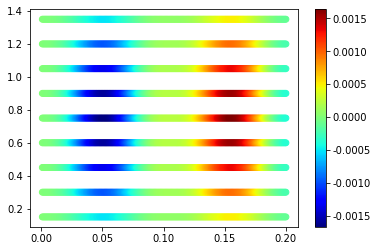

In [6]:
plt.scatter(x4[:,[1]], x4[:, [0]], c=ob_u4, cmap='jet')
plt.colorbar()

(1562.5, 1562.5)

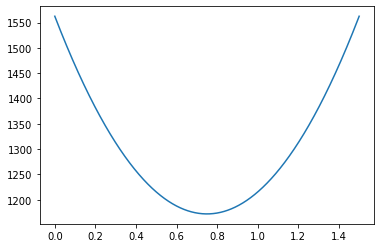

In [7]:
x = np.linspace(0, 1.5, 1000)
def exact_EI(x):
    return 1562.5*((2/3*x-0.5)**2 + 0.75)
EI_exact = exact_EI(x)
plt.plot(x, EI_exact)
EI_exact[-1], EI_exact[0]

## PINN主干网络

In [8]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_k = MLP(mlp_layers_k)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (act4): Tanh()
  (fc5)): Linear(in_features=40, out_features=1, bias=False)
)

## PINN模型

In [9]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [10]:
class PINN(nn.Module):
    def __init__(self, backbone, nn_EI):
        super(PINN, self).__init__()
        self.backbone = backbone
        self.nn_EI = nn_EI

    def forward(self, X_res, u_data, X_bcs_l_train, X_bcs_r_train, X_ics_train):
        f_res_pred = self.net_f(X_res)
        u_pred = self.net_u(X_res)
        u_bcs_l = self.net_bcs(X_bcs_l_train)
        u_bcs_r = self.net_bcs(X_bcs_r_train)
        u_ics = self.net_ics(X_ics_train)

        loss_res_u = torch.mean((f_res_pred) ** 2)
        loss_data_u = torch.mean((u_pred - u_data) ** 2)
        loss_bcs_l = torch.mean((u_bcs_l)**2) + torch.mean(self.net_u(X_bcs_l_train)**2)
        loss_bcs_r = torch.mean((u_bcs_r)**2) + torch.mean(self.net_u(X_bcs_r_train)**2)
        loss_ics = torch.mean((u_ics)**2) + torch.mean(self.net_u(X_ics_train)**2)
        return loss_res_u, loss_data_u, loss_bcs_l, loss_bcs_r, loss_ics
    
    def net_u(self, X):
        # return self.backbone(X)*(1e-2)*(1.5-X[:, [0]])*X[:, [0]]*X[:, [1]]
        return self.backbone(X)*1e-3
    
    def net_EI(self, X):
        x = X[:, [0]]
        return (self.nn_EI(x)*x*(x-1.5))+1562.5
        # return (1e2*self.nn_EI(x)*x*(x-1.5))+1562.5

    def net_bcs(self, X):
        X.requires_grad_(True)
        u_pred = self.net_u(X)

        grad_u = grad(u_pred, X)[0]
        u_x = grad_u[:, [0]]
        u_xx = grad(u_x, X)[0][:, [0]]
        return u_xx

    def net_ics(self, X):
        X.requires_grad_(True)
        u_pred = self.net_u(X)

        grad_u = grad(u_pred, X)[0]
        u_x = grad_u[:, [0]]
        return u_x
    
    def net_f(self, X):
        X.requires_grad_(True)
        u_pred = self.net_u(X)

        grad_u = grad(u_pred, X)[0]
        u_t = grad_u[:, [1]]
        u_x = grad_u[:, [0]]

        u_tt = grad(u_t, X)[0][:, [1]]
        u_xx = grad(u_x, X)[0][:, [0]]
        
        self.EI = self.net_EI(X)
        grad_EI_x = grad((self.EI*u_xx), X)[0][:, [0]]
        grad_EI_xx = grad(grad_EI_x, X)[0][:, [0]]

        q = -20*torch.sin(10*torch.pi*X[:, [1]])

        EI_real = 3e9*0.05*0.05**3/12
        
        f_res_pred = rho*A*u_tt + grad_EI_xx - q
        # f_res_pred = rho*A*u_tt + grad_EI_xx*EI_real - q
        return f_res_pred
    

pinn = PINN(mlp,mlp_k)

In [11]:
# 训练
X_train = torch.tensor(x4, dtype=torch.float32).to(device)
X_bcs_l_train = torch.tensor(x_b_l, dtype=torch.float32).to(device)
X_bcs_r_train = torch.tensor(x_b_r, dtype=torch.float32).to(device)
X_ics_train = torch.tensor(X_ics, dtype=torch.float32).to(device)
u_train = torch.tensor(ob_u4, dtype=torch.float32).to(device)
u_b_l_train = torch.tensor(u_b_l, dtype=torch.float32).to(device)
u_b_r_train = torch.tensor(u_b_r, dtype=torch.float32).to(device)

backbone = MLP(mlp_layers)
nn_EI = MLP(mlp_layers_k)
pinn = PINN(backbone, nn_EI)
pinn = pinn.to(device)

# optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
# optimizer_adam_EI = optim.Adam(pinn.nn_EI.parameters(), lr=learning_rate)

# lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
# lr_sche_EI = ReduceLROnPlateau(optimizer_adam_EI, mode='min', factor=gamma, verbose=True)
# # lr_sche = ExponentialLR(optimizer_adam, gamma=gamma, verbose=True)
# # lr_sche_k = ExponentialLR(optimizer_adam_k, gamma=gamma, verbose=True)

# logger = {
#     "loss": [],
#     "loss_res_u": [],
#     "loss_data_u": [],
#     "loss_bcs_l": [],
#     "loss_bcs_r": [],
#     "loss_ics": [],
#     "iter": []
# }
# with open(train_info_path + 'train_info.txt', 'w') as f:
#     f.write('Training by Adam:\n')
# start_time = time.time()

# for it in range(n_iters):
#     pinn.zero_grad()
#     loss_res_u, loss_data_u, loss_bcs_l, loss_bcs_r, loss_ics = pinn(
#         X_train, u_train, X_bcs_l_train, X_bcs_r_train, X_ics_train)
#     loss = (1e-5)*(loss_res_u) + 1e4*(loss_data_u) + loss_bcs_l + loss_bcs_r + loss_ics
#     loss.backward()
#     optimizer_adam.step()
#     optimizer_adam_EI.step()
    
#     # 保存训练信息 -------
#     logger["loss"].append(loss.item())
#     logger["loss_res_u"].append(loss_res_u.item())
#     logger["loss_data_u"].append(loss_data_u.item())
#     logger["loss_bcs_l"].append(loss_bcs_l.item())
#     logger["loss_bcs_r"].append(loss_bcs_r.item())
#     logger["loss_ics"].append(loss_ics.item())
#     logger["iter"].append(it + 1)

    
#     if (it + 1) % 100 == 0:  # 打印训练信息 -------
#         info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + \
#             f'loss:{loss.item():.2e}, loss_r_u:{loss_res_u.item():.2e}, loss_d_u:{loss_data_u.item():.2e}, ' + \
#             f'loss_b_l:{loss_bcs_l.item():.2e}, loss_b_r:{loss_bcs_r.item():.2e}, loss_i:{loss_ics.item():.2e}'
#         with open(train_info_path + 'train_info.txt', 'a') as f:
#             f.write(info + '\n')
#         print(info)
        
#     if (it + 1) % 100 == 0:  # 学习率衰减 -------
#         lr_sche.step(loss)
#         lr_sche_EI.step(loss)

In [13]:
# model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),
#                'nn_k_state': pinn.nn_EI.state_dict()}
# backbone_path = os.path.join(model_path, f'backbone_adam.pth')
# torch.save(model_state, backbone_path)

# np.save("./loss_logger_dict.npy", logger)

In [ ]:
# def used_time(start_time):
#     seconds = time.time() - start_time
#     minutes, seconds = divmod(seconds, 60)
#     hours, minutes = divmod(minutes, 60)
#     print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')

# used_time(start_time)


used time: 1h 41m 37s


## 结果可视化

In [14]:
plt.rcParams.update({'font.size':18})

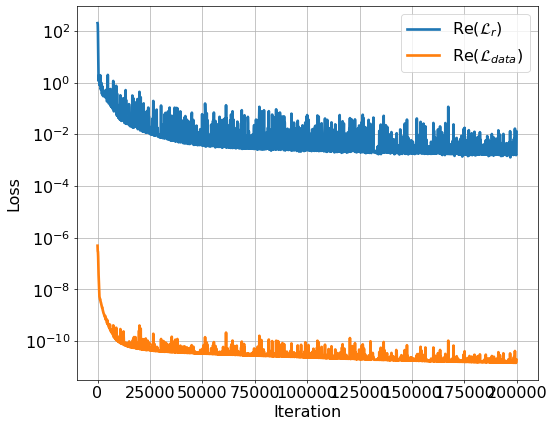

In [15]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_u"]
        [::k], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_u"]
        [::k], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()


In [17]:
backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINN(backbone, nn_k)
pinn = pinn.to(device)
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'), map_location=torch.device('cpu'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_EI.load_state_dict(model_state['nn_k_state'])


<All keys matched successfully>

In [18]:
data = scio.loadmat(file_name)
t = data['tt1']
x = data['xx']
tt, xx = np.meshgrid(t, x)
u_exact = data['D'][1::2,1::]
X = np.concatenate([xx.reshape(-1,1), tt.reshape(-1,1)], axis=1)
X = torch.tensor(X).float().to(device)

u_pred = pinn.net_u(X).cpu().detach().numpy()
EI_pred = pinn.net_EI(X).cpu().detach().numpy()


def exact_EI(x):
    return 1562.5*((2/3*x-0.5)**2 + 0.75)

EI_exact = exact_EI(X[:,[0]]).cpu().detach().numpy()

In [19]:
error_u = np.linalg.norm(u_exact - u_pred.reshape(tt.shape)) / np.linalg.norm(u_exact)
error_EI = np.linalg.norm(
    EI_exact - EI_pred) / np.linalg.norm(EI_exact)
print('u Relative l2 error: {:.3e}'.format(error_u))
print('EI Relative l2 error: {:.3e}'.format(error_EI))


u Relative l2 error: 7.598e-02
EI Relative l2 error: 6.106e-02


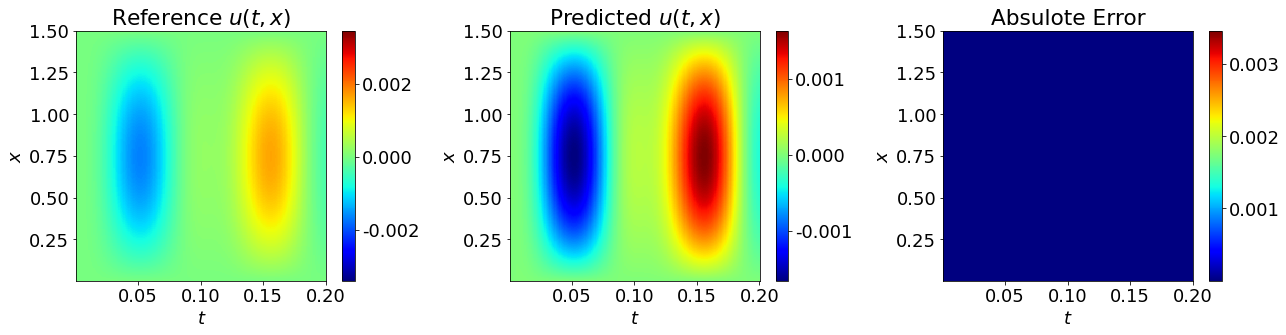

In [20]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(3, figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.pcolor(tt, xx, u_exact.reshape(tt.shape),  cmap='jet')
# plt.pcolor(xx, yy, S_pred_3,  cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $u(t,x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = plt.subplot(1, 3, 2)
# plt.pcolor(X, Y, S_pred, cmap='jet', vmin=-1, vmax=1)
plt.pcolor(tt, xx, u_pred.reshape(tt.shape),  cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(t,x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = plt.subplot(1, 3, 3)
plt.pcolor(tt, xx, np.abs(u_exact.reshape(tt.shape) -
           u_pred.reshape(tt.shape)), cmap='jet')
cbar = plt.colorbar()
# cbar.formatter.set_powerlimits((0,0))
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Absulote Error')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())


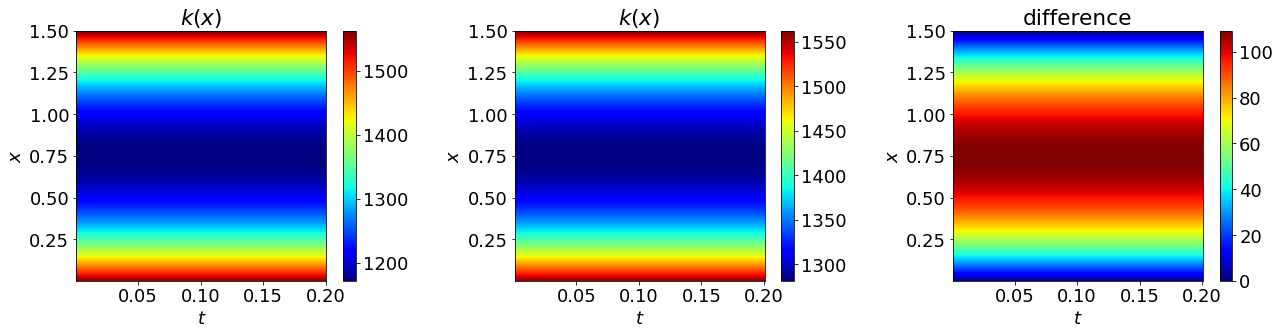

In [21]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(3, figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.pcolor(tt, xx, EI_exact.reshape(tt.shape),  cmap='jet')
# plt.pcolor(xx, yy, S_pred_3,  cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$k(x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = plt.subplot(1, 3, 2)
# plt.pcolor(X, Y, S_pred, cmap='jet', vmin=-1, vmax=1)
plt.pcolor(tt, xx, EI_pred.reshape(tt.shape),  cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$k(x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = plt.subplot(1, 3, 3)
plt.pcolor(tt, xx, np.abs(EI_exact.reshape(tt.shape) -
           EI_pred.reshape(tt.shape)), cmap='jet')
cbar = plt.colorbar()
# cbar.formatter.set_powerlimits((0,0))
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'difference')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())


In [22]:
observe_u3()[0][:,0:2].shape, EI_pred.max()

((1800, 2), 1562.5)

In [29]:
print(tt.shape, tt.shape[0])

(1500, 200) 1500


(1500, 1) (1500, 1)
(1500,)


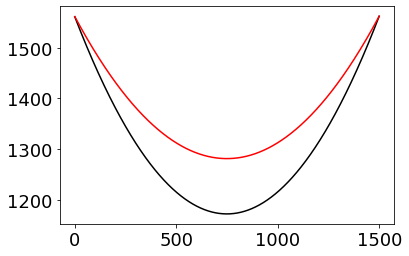

In [35]:
EI_exact_plot = EI_exact.reshape(tt.shape)[:, [0]]
EI_pred_plot = EI_pred.reshape(tt.shape)[:, [0]]
print(EI_exact_plot.shape, EI_pred_plot.shape)
x = np.arange(0, tt.shape[0])
print(x.shape)
plt.plot(x,EI_exact_plot,label="exact",color="black")
plt.plot(x,EI_pred_plot,label="PINN",color="red")


# plt.plot(x_allpoint(x)[:,1].reshape(-1,1),u_pred.reshape(-1,1),label="PINN",color="red")
# plt.plot(x_allpoint(x)[:,1][::5],x_allpoint(x)[:,2][::5],"o",markersize=5,label="exact",color="black" )

(200, 1) (200,)
torch.Size([1001, 2])


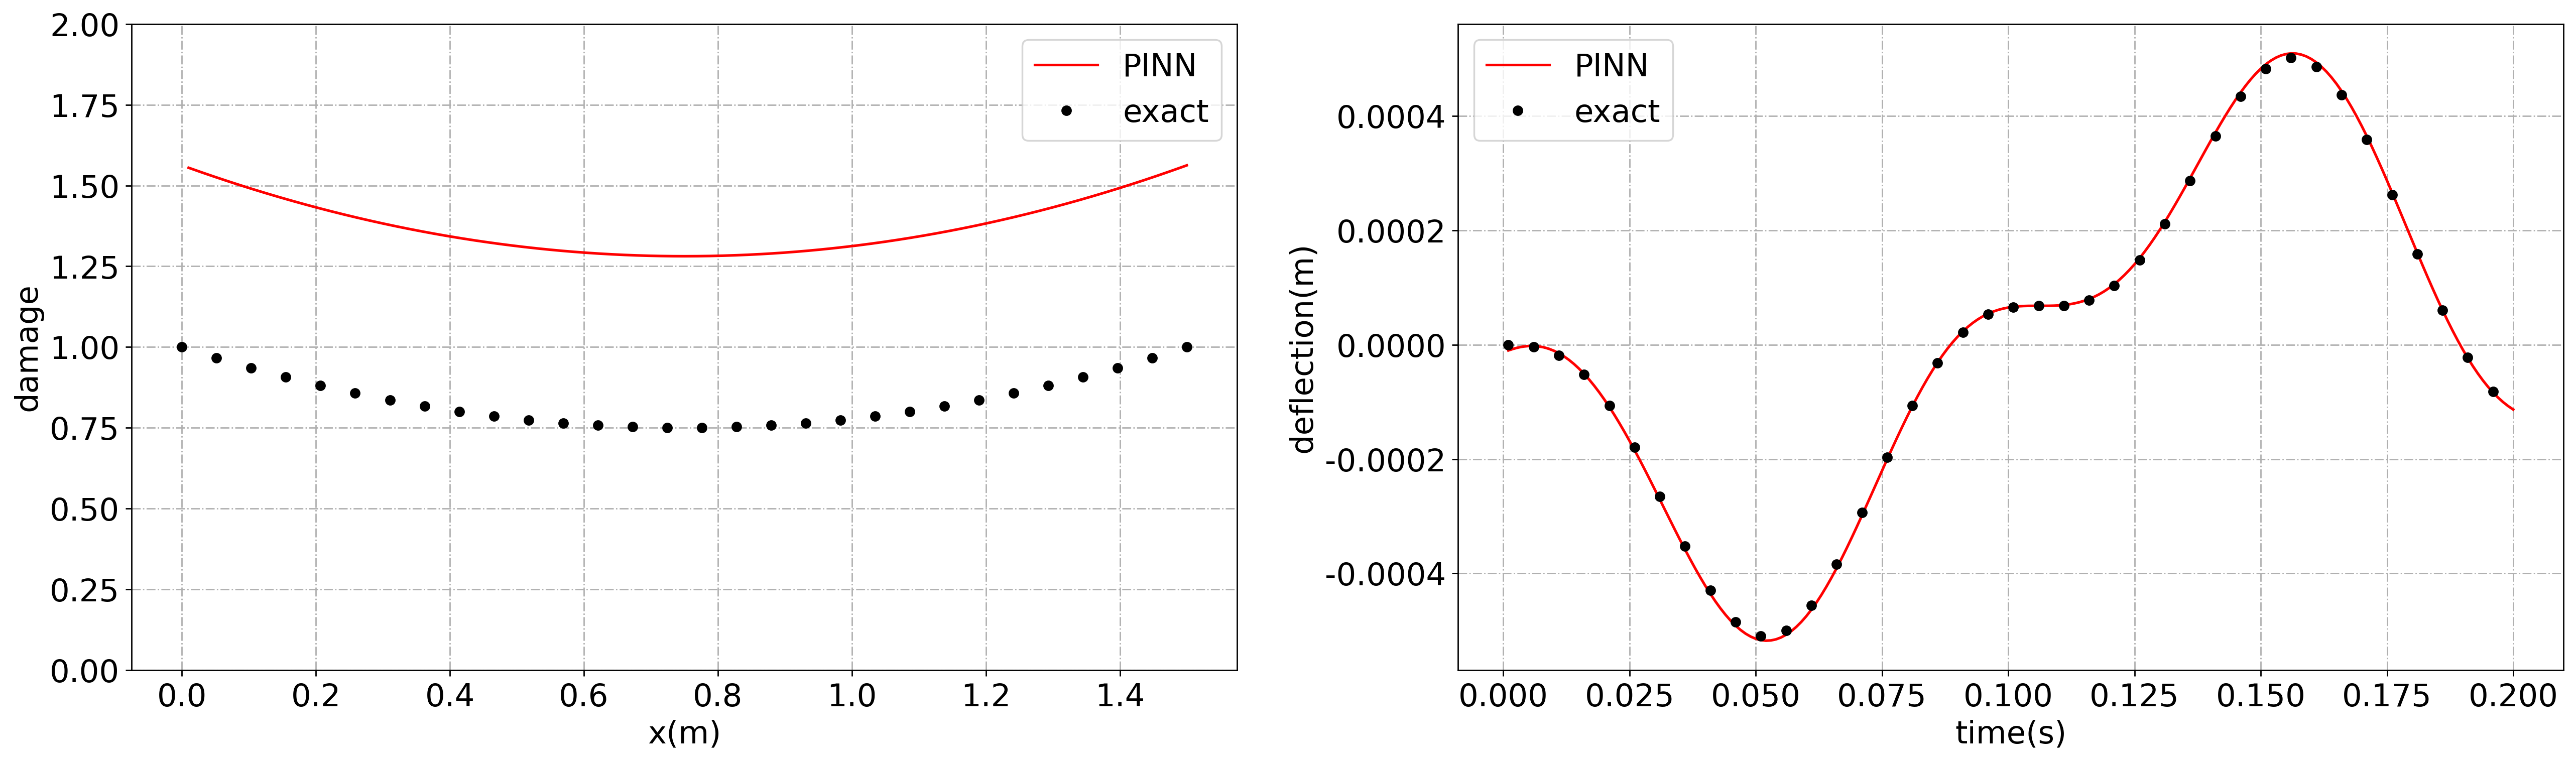

In [34]:
plt.rcParams.update({'font.size': 18})
X=np.vstack((np.full((1001), 0.75), np.linspace(0, 0.2, num=1001))).T
#E_exact=np.linspace(1, 1, num=1001)
x_E=np.linspace(0, 1.5, num=30)
E_exact = (x_E*0.04/1.5+0.04)/(0.05)*0+0.75+(x_E/1.5-0.5)**2

plt.figure(dpi=250,figsize=(25,15))
plt.subplot(2,2,2)
i=0
x,yreal=observe_u3()[i][:,1:2],observe_u3()[i][:,2:3]

X = observe_u3()[i][:, 0:2]
X = torch.tensor(X).float().to(device)
y_hat=pinn.net_u(X).cpu().detach().numpy()
# plotpde(observe_u()[space*i:space*(i+1)][:,0:2],'y')
# plt.plot(x,y_hat[:,0:1],color='red',label='PINN')
# plt.plot(x[::5],yreal[::5],"o",markersize=5,color='black',label='exact')
x=0.15
X  = x_allpoint(x)[:, 0:2]
X = torch.tensor(X).float().to(device)
u_pred = pinn.net_u(X)[:, 0].cpu().detach().numpy()
print(u_pred.reshape(-1, 1).shape, x_allpoint(x)[:, 1].shape)
plt.plot(x_allpoint(x)[:,1].reshape(-1,1),u_pred.reshape(-1,1),label="PINN",color="red")
plt.plot(x_allpoint(x)[:,1][::5],x_allpoint(x)[:,2][::5],"o",markersize=5,label="exact",color="black" )
plt.grid(linestyle='-.')
plt.xlabel('time(s)')
plt.ylabel('deflection(m)')
plt.legend()

X=np.vstack((np.linspace(0.01, 1.5, num=1001),np.full((1001), 0.1))).T
X = torch.tensor(X).float().to(device)
print(X.shape)
plt.subplot(2,2,1)
# plt.plot(X[:, 0:1].cpu().detach().numpy(), pinn.net_u(X).cpu().detach().numpy(), "-", label="PINN", color="red")
plt.plot(X[:, 0:1].cpu().detach().numpy(), pinn.net_EI(X).cpu().detach().numpy()/1000, "-", label="PINN", color="red")
plt.plot(x_E,E_exact,"o",markersize=5,label="exact",color="black")
plt.ylim(0,2)
plt.grid(linestyle='-.')
plt.ylabel("damage")
plt.xlabel('x(m)')
plt.legend()

In [ ]:
pinn.net_u(X).cpu().detach().numpy(), X[:, 0:1]


(array([[ 3.8701296e-06],
        [ 4.5347215e-06],
        [ 5.2000287e-06],
        ...,
        [ 1.2815000e-06],
        [ 6.1750416e-07],
        [-4.6968463e-08]], dtype=float32),
 tensor([[0.0100],
         [0.0115],
         [0.0130],
         ...,
         [1.4970],
         [1.4985],
         [1.5000]], device='cuda:0'))

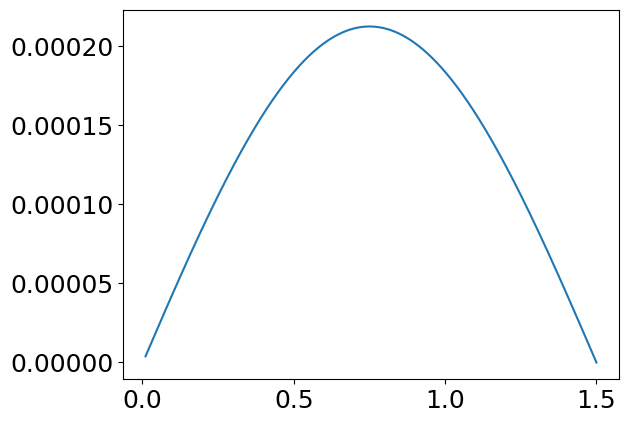

In [ ]:
plt.plot(X[:, 0:1].cpu().detach().numpy(), pinn.net_u(X).cpu().detach().numpy())


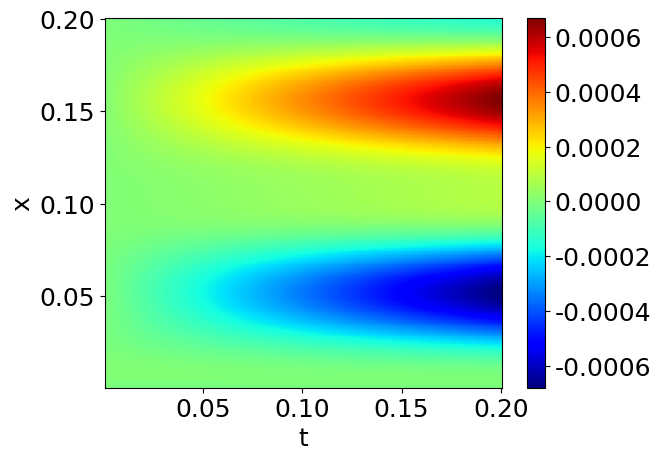

In [ ]:
x = 0.15
X = x_allpoint(x)[:, 0:2]
t, x = X[:, [1]], X[:, [1]]
tt, xx = np.meshgrid(t, x)

X = np.concatenate([tt.reshape(-1,1), xx.reshape(-1,1)], axis=1)
X = torch.tensor(X).float().to(device)
u_pred = pinn.net_u(X).cpu().detach().numpy()
plt.pcolor(tt, xx, u_pred.reshape(tt.shape), cmap='jet')

plt.ylabel("x")
plt.xlabel('t')
plt.colorbar()

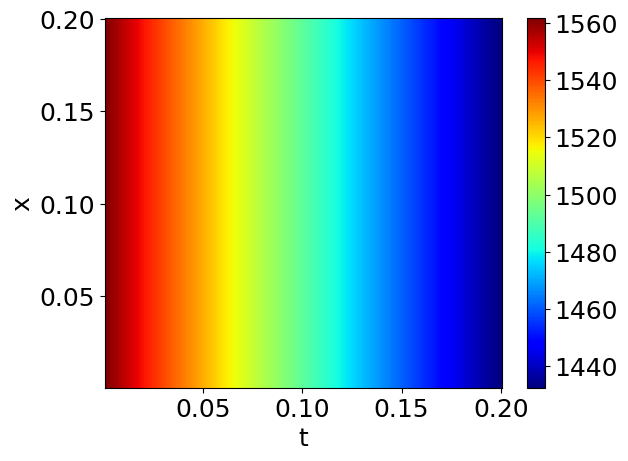

In [ ]:
x = 0.15
X = x_allpoint(x)[:, 0:2]
t, x = X[:, [1]], X[:, [1]]
tt, xx = np.meshgrid(t, x)

X = np.concatenate([tt.reshape(-1, 1), xx.reshape(-1, 1)], axis=1)
X = torch.tensor(X).float().to(device)
EI_pred = pinn.net_EI(X).cpu().detach().numpy()

plt.pcolor(tt, xx, EI_pred.reshape(tt.shape), cmap='jet')

plt.ylabel("x")
plt.xlabel('t')
plt.colorbar()


In [ ]:
X=np.vstack((np.linspace(0, 1.5, num=1001),np.full((1001), 0.1))).T
E_exact = (X[:,0:1]*0.04/1.5+0.04)/(0.05)*0+0.75+(X[:,0:1]/1.5-0.5)**2
plt.figure(dpi=100,figsize=(8,4))
X = torch.tensor(X).float().to(device)
u_pred = pinn.net_u(X)[:, 1:2].cpu().detach().numpy()
print(u_pred)
print(u_pred, u_pred.reshape(-1, 1).shape, E_exact.shape)
print((u_pred-E_exact.reshape(-1, 1)).shape)
plt.plot(X[:,0:1],(u_pred.reshape(-1,1)-E_exact.reshape(-1,1))/E_exact.reshape(-1,1),"-",label="relative error",color="black")
# plt.ylim(0,2)
plt.grid(linestyle='-.')
plt.ylabel("error")
plt.xlabel("x(m)")
plt.legend(labels=['pinn'])

[]
[] (0, 1) (1001, 1)
(1001, 0)


ValueError: operands could not be broadcast together with shapes (0,1) (1001,1) 

<Figure size 800x400 with 0 Axes>